In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_dir = "/content/drive/MyDrive/Edge Final Project/Yahoo Dataset/clustering_scaled_data/"
out_dir = "/content/drive/MyDrive/Edge Final Project/Clustering results/"

In [6]:
# data is scaled (locally with 20-day window) and na-filled by Ismail and Michelle

df = pd.read_csv(data_dir + "middle_interpolated.csv", index_col=0)
df.shape

(1265, 175)

# Fit Fourier coefs

In [7]:
from scipy.fft import fft, ifft, fftfreq
from sklearn.cluster import KMeans

In [8]:
N = df.shape[0]
T = 1.0 / N
top_coefficients = {}

for stock in df.columns:
    prices = df[stock].values

    yf = fft(prices)
    xf = fftfreq(N, T)[:N//2]

    magnitude = yf[0:N//2]
    top_indices = np.argsort(np.abs(magnitude))
    top_coefficients[stock] = {
        "frequencies": xf[top_indices],
        "magnitudes": magnitude[top_indices]
    }

top_coefficients['3IN']['magnitudes'][0]

(0.487057464228263+0.8202840479524292j)

In [9]:
time = np.linspace(0, (N-1)*T, N)

reconstructed_signals = {}
for stock in df.columns:

    # # This doesn't work because we can't keep norms only
    # top_frequencies = top_coefficients[stock]["frequencies"]
    # top_magnitudes = top_coefficients[stock]["magnitudes"]
    # reconstructed_signal = np.zeros_like(time)
    # for i in range(len(top_frequencies)):
    #     reconstructed_signal += top_magnitudes[i] * np.sin(2 * np.pi * top_frequencies[i] * time)
    # reconstructed_signals[stock] = reconstructed_signal

    prices = df[stock].values
    yf = fft(prices)
    for n_coef in [5, 10, 15]:
        if n_coef not in reconstructed_signals.keys():
            reconstructed_signals[n_coef] = {}

        filtered_yf = np.zeros_like(yf, dtype=complex)
        top_indices = np.argsort(np.abs(yf[:N//2]))[-n_coef:]
        for idx in top_indices:
            filtered_yf[idx] = yf[idx]
            filtered_yf[-idx] = yf[-idx]

        reconstructed_signal = ifft(filtered_yf)
        reconstructed_signals[n_coef][stock] = reconstructed_signal.real

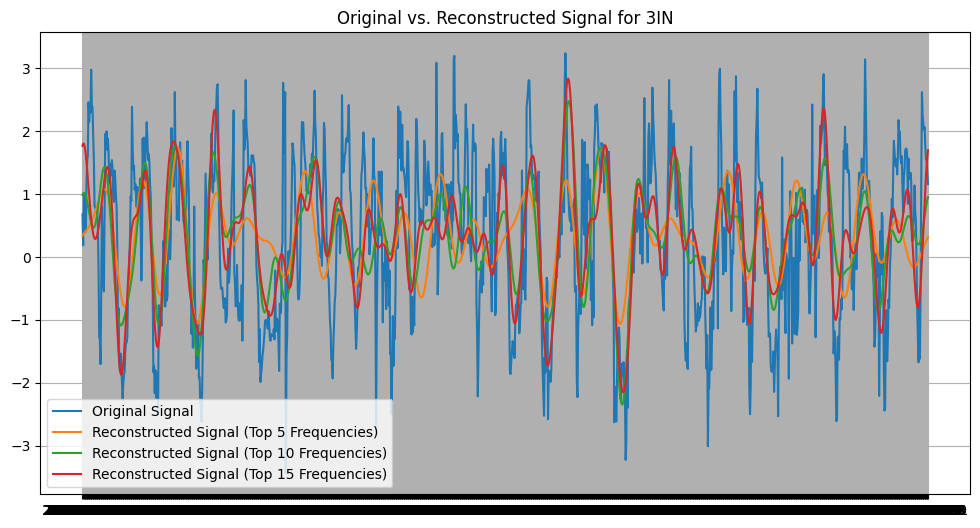

In [10]:
stock = df.columns[0]

plt.figure(figsize=(12, 6))
plt.plot(df.index, df[stock], label="Original Signal")
for n_coef in [5, 10, 15]:
    plt.plot(df.index, reconstructed_signals[n_coef][stock],
             label=f"Reconstructed Signal (Top {n_coef} Frequencies)")
plt.title(f"Original vs. Reconstructed Signal for {stock}")
plt.legend()
plt.grid()
plt.show()

# I think 10 components are good enough

In [11]:
n_coef = 10

N = df.shape[0]
T = 1.0 / N
top_coefficients = {}

for stock in df.columns:
    prices = df[stock].values

    yf = fft(prices)
    xf = fftfreq(N, T)[:N//2]

    magnitude = yf[0:N//2]
    top_indices = np.argsort(np.abs(magnitude))[-n_coef:]
    top_coefficients[stock] = {
        "frequencies": xf[top_indices],
        "magnitudes": magnitude[top_indices]
    }

coef_df = pd.DataFrame({
    stock: {
        **{f"freq_{i+1}": coeffs["frequencies"][i] for i in range(n_coef)},
        **{f"mag_{i+1}": np.abs(coeffs["magnitudes"][i]) for i in range(n_coef)}
    }
    for stock, coeffs in top_coefficients.items()
}).T

coef_df.head()

,freq_1,freq_2,freq_3,freq_4,freq_5,freq_6,freq_7,freq_8,freq_9,freq_10,mag_1,mag_2,mag_3,mag_4,mag_5,mag_6,mag_7,mag_8,mag_9,mag_10
3IN,7.0,23.0,10.0,40.0,24.0,20.0,12.0,22.0,26.0,0.0,167.319788,179.324364,194.656253,208.942560,212.358668,216.508592,224.740112,263.370033,305.440022,416.070267
FOUR,47.0,45.0,12.0,50.0,29.0,13.0,15.0,8.0,11.0,18.0,149.755808,180.969111,184.067556,191.773994,203.082374,215.772812,248.594779,249.246737,251.259366,274.939946
ABDN,2.0,21.0,37.0,24.0,9.0,14.0,29.0,23.0,3.0,17.0,207.736086,209.534850,211.507428,212.163964,213.891831,217.747380,221.471507,237.419308,241.380862,259.864957
ALW,20.0,24.0,35.0,12.0,36.0,10.0,27.0,17.0,26.0,0.0,157.649033,159.186904,161.711715,191.754130,198.871438,204.816706,217.164449,242.710415,307.603318,465.987234
ATT,27.0,28.0,6.0,21.0,17.0,11.0,25.0,29.0,26.0,0.0,164.250223,167.856438,170.231367,171.764297,189.176728,189.194244,197.304272,212.515708,228.933549,599.528489


# K-means Clustering on Fourier Coefficients

In [12]:
from sklearn.cluster import KMeans

In [13]:
coef_df_scaled = (coef_df - coef_df.mean()) / coef_df.std()
coef_df_scaled.head()

,freq_1,freq_2,freq_3,freq_4,freq_5,freq_6,freq_7,freq_8,freq_9,freq_10,mag_1,mag_2,mag_3,mag_4,mag_5,mag_6,mag_7,mag_8,mag_9,mag_10
3IN,-0.974015,0.110767,-0.693261,1.384091,0.372557,0.069897,-0.485149,0.465592,0.856101,-0.934310,-0.439111,-0.061863,0.595304,0.971578,0.484273,0.040190,-0.243267,0.845901,1.289812,0.878046
FOUR,1.834101,1.639275,-0.551614,2.120981,0.781063,-0.508644,-0.221481,-0.767597,-0.516694,0.666058,-1.794349,0.063937,-0.225640,-0.335069,-0.132525,-0.004399,1.135539,0.215606,-0.631633,-0.759907
ABDN,-1.325030,-0.028188,1.218974,0.205066,-0.852960,-0.425995,1.008968,0.553677,-1.248851,0.577149,2.679412,2.248819,1.901780,1.216749,0.586216,0.115262,-0.432193,-0.312228,-0.981960,-0.934867
ALW,-0.061377,0.180245,1.077327,-0.679203,1.352971,-0.756590,0.833190,0.025167,0.856101,-0.934310,-1.185307,-1.602098,-1.958894,-0.336581,-0.412518,-0.668351,-0.681143,-0.076097,1.366530,1.457381
ATT,0.430043,0.458155,-0.976555,-0.016001,-0.199351,-0.673941,0.657411,1.082186,0.856101,-0.934310,-0.675959,-0.939000,-1.298363,-1.857946,-1.057137,-1.615089,-1.829066,-1.423627,-1.423388,3.007256


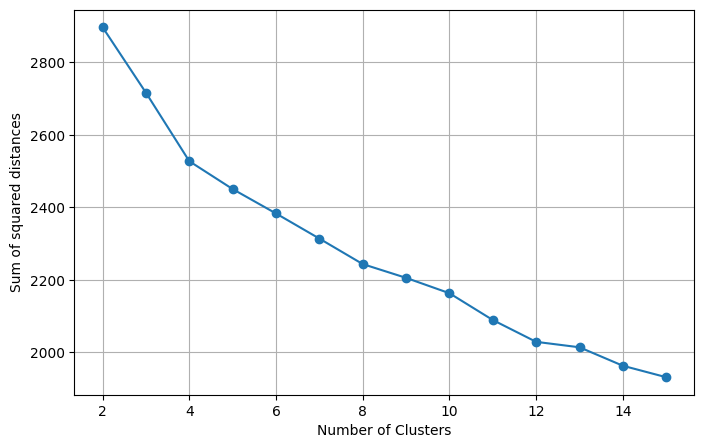

In [34]:
inertia = []
K_range = range(2, 16)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coef_df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of squared distances")  # this is equivalent to inertia
plt.grid()
plt.show()

In [15]:
K = 5
kmeans = KMeans(n_clusters=K, random_state=42)
labels = kmeans.fit_predict(coef_df_scaled)\

cluster_df = pd.DataFrame({
    "stock": coef_df.index,
    "cluster": labels
})
cluster_df.to_csv(out_dir + "fft_direct_kmeans_5_cluster_df.csv", index=False)

In [16]:
K = 8
kmeans = KMeans(n_clusters=K, random_state=42)
labels = kmeans.fit_predict(coef_df_scaled)\

cluster_df = pd.DataFrame({
    "stock": coef_df.index,
    "cluster": labels
})
cluster_df.to_csv(out_dir + "fft_direct_kmeans_8_cluster_df.csv", index=False)

# Hierachical using set distance

naive K-means compare freq_1 only with other freq_1, but two stocks can be similar if one's top 1 is the other's top 2 and the other's top 2 is one's top 1. Here I try to solve this using set distance with a hierachical clustering.

This clustering is very **imbalanced**

In [29]:
# from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering
from scipy.optimize import linear_sum_assignment

In [28]:
n_coef = 10

stock_features = [
    np.concatenate([
        coef_df.loc[stock, [f"freq_{i+1}" for i in range(n_coef)]].values,
        coef_df.loc[stock, [f"mag_{i+1}" for i in range(n_coef)]].values
    ])
    for stock in coef_df.index
]

# # This is not the most justifiable way
# distance_matrix = cdist(stock_features, stock_features, metric="euclidean")
# distance_matrix.shape

In [30]:
def compute_distance(feature1, feature2):
    freqs1, mags1 = feature1[:n_coef], feature1[n_coef:]
    freqs2, mags2 = feature2[:n_coef], feature2[n_coef:]
    cost_matrix = np.zeros((n_coef, n_coef))
    for i in range(n_coef):
        for j in range(n_coef):
            cost_matrix[i, j] = abs(freqs1[i] - freqs2[j]) * abs(mags1[i] + mags2[j])
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return cost_matrix[row_ind, col_ind].sum()

In [31]:
distance_matrix = np.zeros((len(stock_features), len(stock_features)))
for i in range(len(stock_features)):
    for j in range(i, len(stock_features)):
        distance = compute_distance(stock_features[i], stock_features[j])
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance

In [32]:
n_cluster = 5
clustering = AgglomerativeClustering(
    n_clusters=n_cluster, metric="precomputed", linkage="average"
)
labels = clustering.fit_predict(distance_matrix)
cluster_df = pd.DataFrame({
    "stock": coef_df.index,
    "cluster": labels
})
# cluster_df.to_csv(out_dir + "fft_set_agglomerative_5_cluster_df.csv", index=False)

In [33]:
n_cluster = 8
clustering = AgglomerativeClustering(
    n_clusters=n_cluster, metric="precomputed", linkage="average"
)
labels = clustering.fit_predict(distance_matrix)
cluster_df = pd.DataFrame({
    "stock": coef_df.index,
    "cluster": labels
})
# cluster_df.to_csv(out_dir + "fft_set_agglomerative_8_cluster_df.csv", index=False)